# Trabajo Práctico 1 : Reservas de Hotel

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

### Cargado de bibliotecas

In [2]:
# Manipulacion de datos y funciones matemáticas
import pandas as pd
import numpy as np
import sklearn as sk

# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split,  StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

### Cargado de Dataset

In [3]:
ds = pd.read_csv('../datasets/hoteles_train2.csv')
ds_test = pd.read_csv('../datasets/hotels_test.csv')

### Definicion de excluidos y target 

In [4]:
excluidos = ['hotel', 'reservation_status_date', 'id']

target = 'is_canceled'
features = [col for col in ds.columns if col not in excluidos+[target]]
print(features, '\n', target)

['lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests'] 
 is_canceled


### Trabajo sobre valores nulos

In [5]:
agents = ds['agent'].unique()
agents = np.delete(agents, 1)
ds['agent'].fillna(0, inplace=True)

agents = ds_test['agent'].unique()
agents = np.delete(agents, 1)
ds_test['agent'].fillna(0, inplace=True)

### Transformacion de Variable Categoricas

In [6]:
import string

ds = ds.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 4},# ver que hacer con undefined
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

ds_test = ds_test.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 4},# ver que hacer con undefined
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

# Si meal es Undefined o vacío, reemplazamos por SC (dice el paper)
# ds['meal'] = ds['meal'].apply(lambda x: 'SC' if x in ['Undefined', 'null', ''] else x)
# ds = pd.get_dummies(ds, columns=['assigned_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['reserved_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['meal'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['deposit_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['agent'], drop_first=True)


In [7]:
label_encoder = LabelEncoder()
ds['market_segment'] = label_encoder.fit_transform(ds['market_segment'])
ds['distribution_channel'] = label_encoder.fit_transform(ds['distribution_channel'])
ds['customer_type'] = label_encoder.fit_transform(ds['customer_type'])

ds_test['market_segment'] = label_encoder.fit_transform(ds_test['market_segment'])
ds_test['distribution_channel'] = label_encoder.fit_transform(ds_test['distribution_channel'])
ds_test['customer_type'] = label_encoder.fit_transform(ds_test['customer_type'])

#ds['arrival_date_month'] = label_encoder.fit_transform(ds['arrival_date_month'])

### Observacion de procentaje de cancelaciones sobre el total de datos de la columna is_canceled

In [8]:
ds['is_canceled'].value_counts(normalize=True)*100

1    50.013773
0    49.986227
Name: is_canceled, dtype: float64

### Division de set de Evaluacion

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(ds[features].values, 
                                                    ds[target].values, 
                                                    test_size=0.2,
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=ds[target].values) #estratificado para mantener proporcion

print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 49370
# Datos Prueba: 12343
% Positivos Entrenamiento: 50.014
% Positivos Prueba: 50.012


### Buscamos los mejores hiperparámetros

In [10]:
X = ds[features].values
y = ds[target].values

# Parametros
n = 5000

# Utilizamos 6 folds
FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)

# Consideramos adecuado usar la metrica F1-score
scorer_fn = make_scorer(sk.metrics.f1_score)

parametros = {'criterion': ['gini', 'entropy'],
                'min_samples_leaf': list(range(1, 10)),
                'min_samples_split': list(range(2, 20)),
                'ccp_alpha': np.linspace(0, 0.005, n),
                'max_depth': list(range(1, 10))
}

# Optimizacion de los hiperparametros
modelo = tree.DecisionTreeClassifier()
grid = RandomizedSearchCV(modelo, parametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, n_iter=n)

# Entrenado del modelo
grid.fit(X, y)

print(grid.best_score_)
print(grid.best_params_)


KeyboardInterrupt: 

In [11]:
#Anotamos los mejores parametros para no tener que correr todo de nuevo
#best_params = {'min_samples_split': 13, 'min_samples_leaf': 7, 'max_depth': 9, 'criterion': 'gini', 'ccp_alpha': 0.0011111111111111111}
best_params = {'min_samples_split': 12, 'min_samples_leaf': 2, 'max_depth': 19, 'criterion': 'gini', 'ccp_alpha': 7.201440288057611e-05}

### Grafico del arbol con mejor performance encontrado

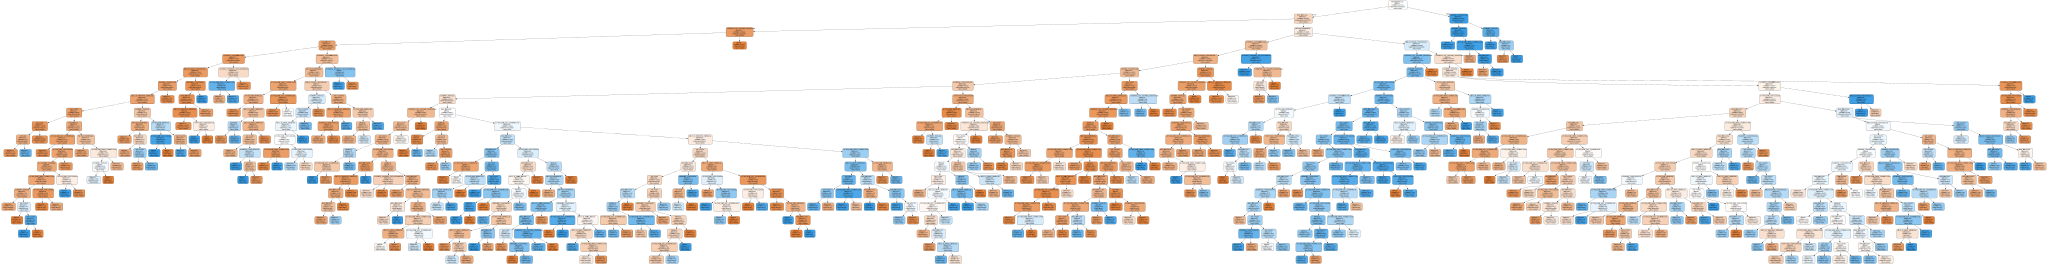

In [12]:
from sklearn.tree import export_graphviz
import graphviz

mejor_arbol = tree.DecisionTreeClassifier(
    criterion=best_params['criterion'], 
    max_depth=best_params['max_depth'], 
    min_samples_leaf=best_params['min_samples_leaf'], 
    min_samples_split=best_params['min_samples_split'], 
    ccp_alpha=best_params['ccp_alpha'])
mejor_arbol.fit(X, y)

dot_data = export_graphviz(mejor_arbol, 
                           out_file=None, 
                           feature_names=features, 
                           class_names=['good', 'bad'], 
                           filled=True, 
                           rounded=True, 
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("mejor_arbol")
graph


In [13]:
reglas = tree.export_text(mejor_arbol, feature_names=features)
print(reglas)

|--- deposit_type <= 1.50
|   |--- lead_time <= 11.50
|   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |--- lead_time <= 7.50
|   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |--- total_of_special_requests <= 0.50
|   |   |   |   |   |   |--- booking_changes <= 0.50
|   |   |   |   |   |   |   |--- stays_in_weekend_nights <= 1.50
|   |   |   |   |   |   |   |   |--- adr <= 78.35
|   |   |   |   |   |   |   |   |   |--- adr <= 24.00
|   |   |   |   |   |   |   |   |   |   |--- adr <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- adr >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- adr >  24.00
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- adr >  78.35
|   |   |   |   |   |   |   |   |   |--- lead_time <= 2.50
|   |   |   |   |   |   |   |   |   |   |--- arrival_date_day_of_month <= 6.50
|  

Explicacion de las primeras reglas de arbol:

Si el tipo de depósito (deposit_type) es menor o igual a 1.5, y el tiempo de anticipación (lead_time) es menor o igual a 11.5, y la cantidad de espacios de estacionamiento de autos requeridos (required_car_parking_spaces) es menor o igual a 0.5, entonces el resultado es 0, lo que indica que la reserva no fue cancelada. Si required_car_parking_spaces es mayor que 0.5, la reserva también se considera no cancelada. En caso contrario, si lead_time es mayor a 11.5 y el segmento de mercado (market_segment) es mayor que 5.5, entonces la reserva se considera cancelada.

Si el tipo de depósito es mayor que 1.5, entonces si el número de reservas anteriores no canceladas (previous_bookings_not_canceled) es menor o igual a 0.5, y el tipo de cliente (customer_type) es menor o igual a 2.5, entonces la reserva se considera cancelada. Si tipo de cliente (customer_type) es mayor que 2.5, la reserva también se considera cancelada. En caso contrario, si previous_bookings_not_canceled es mayor que 0.5, entonces la reserva se considera no cancelada.

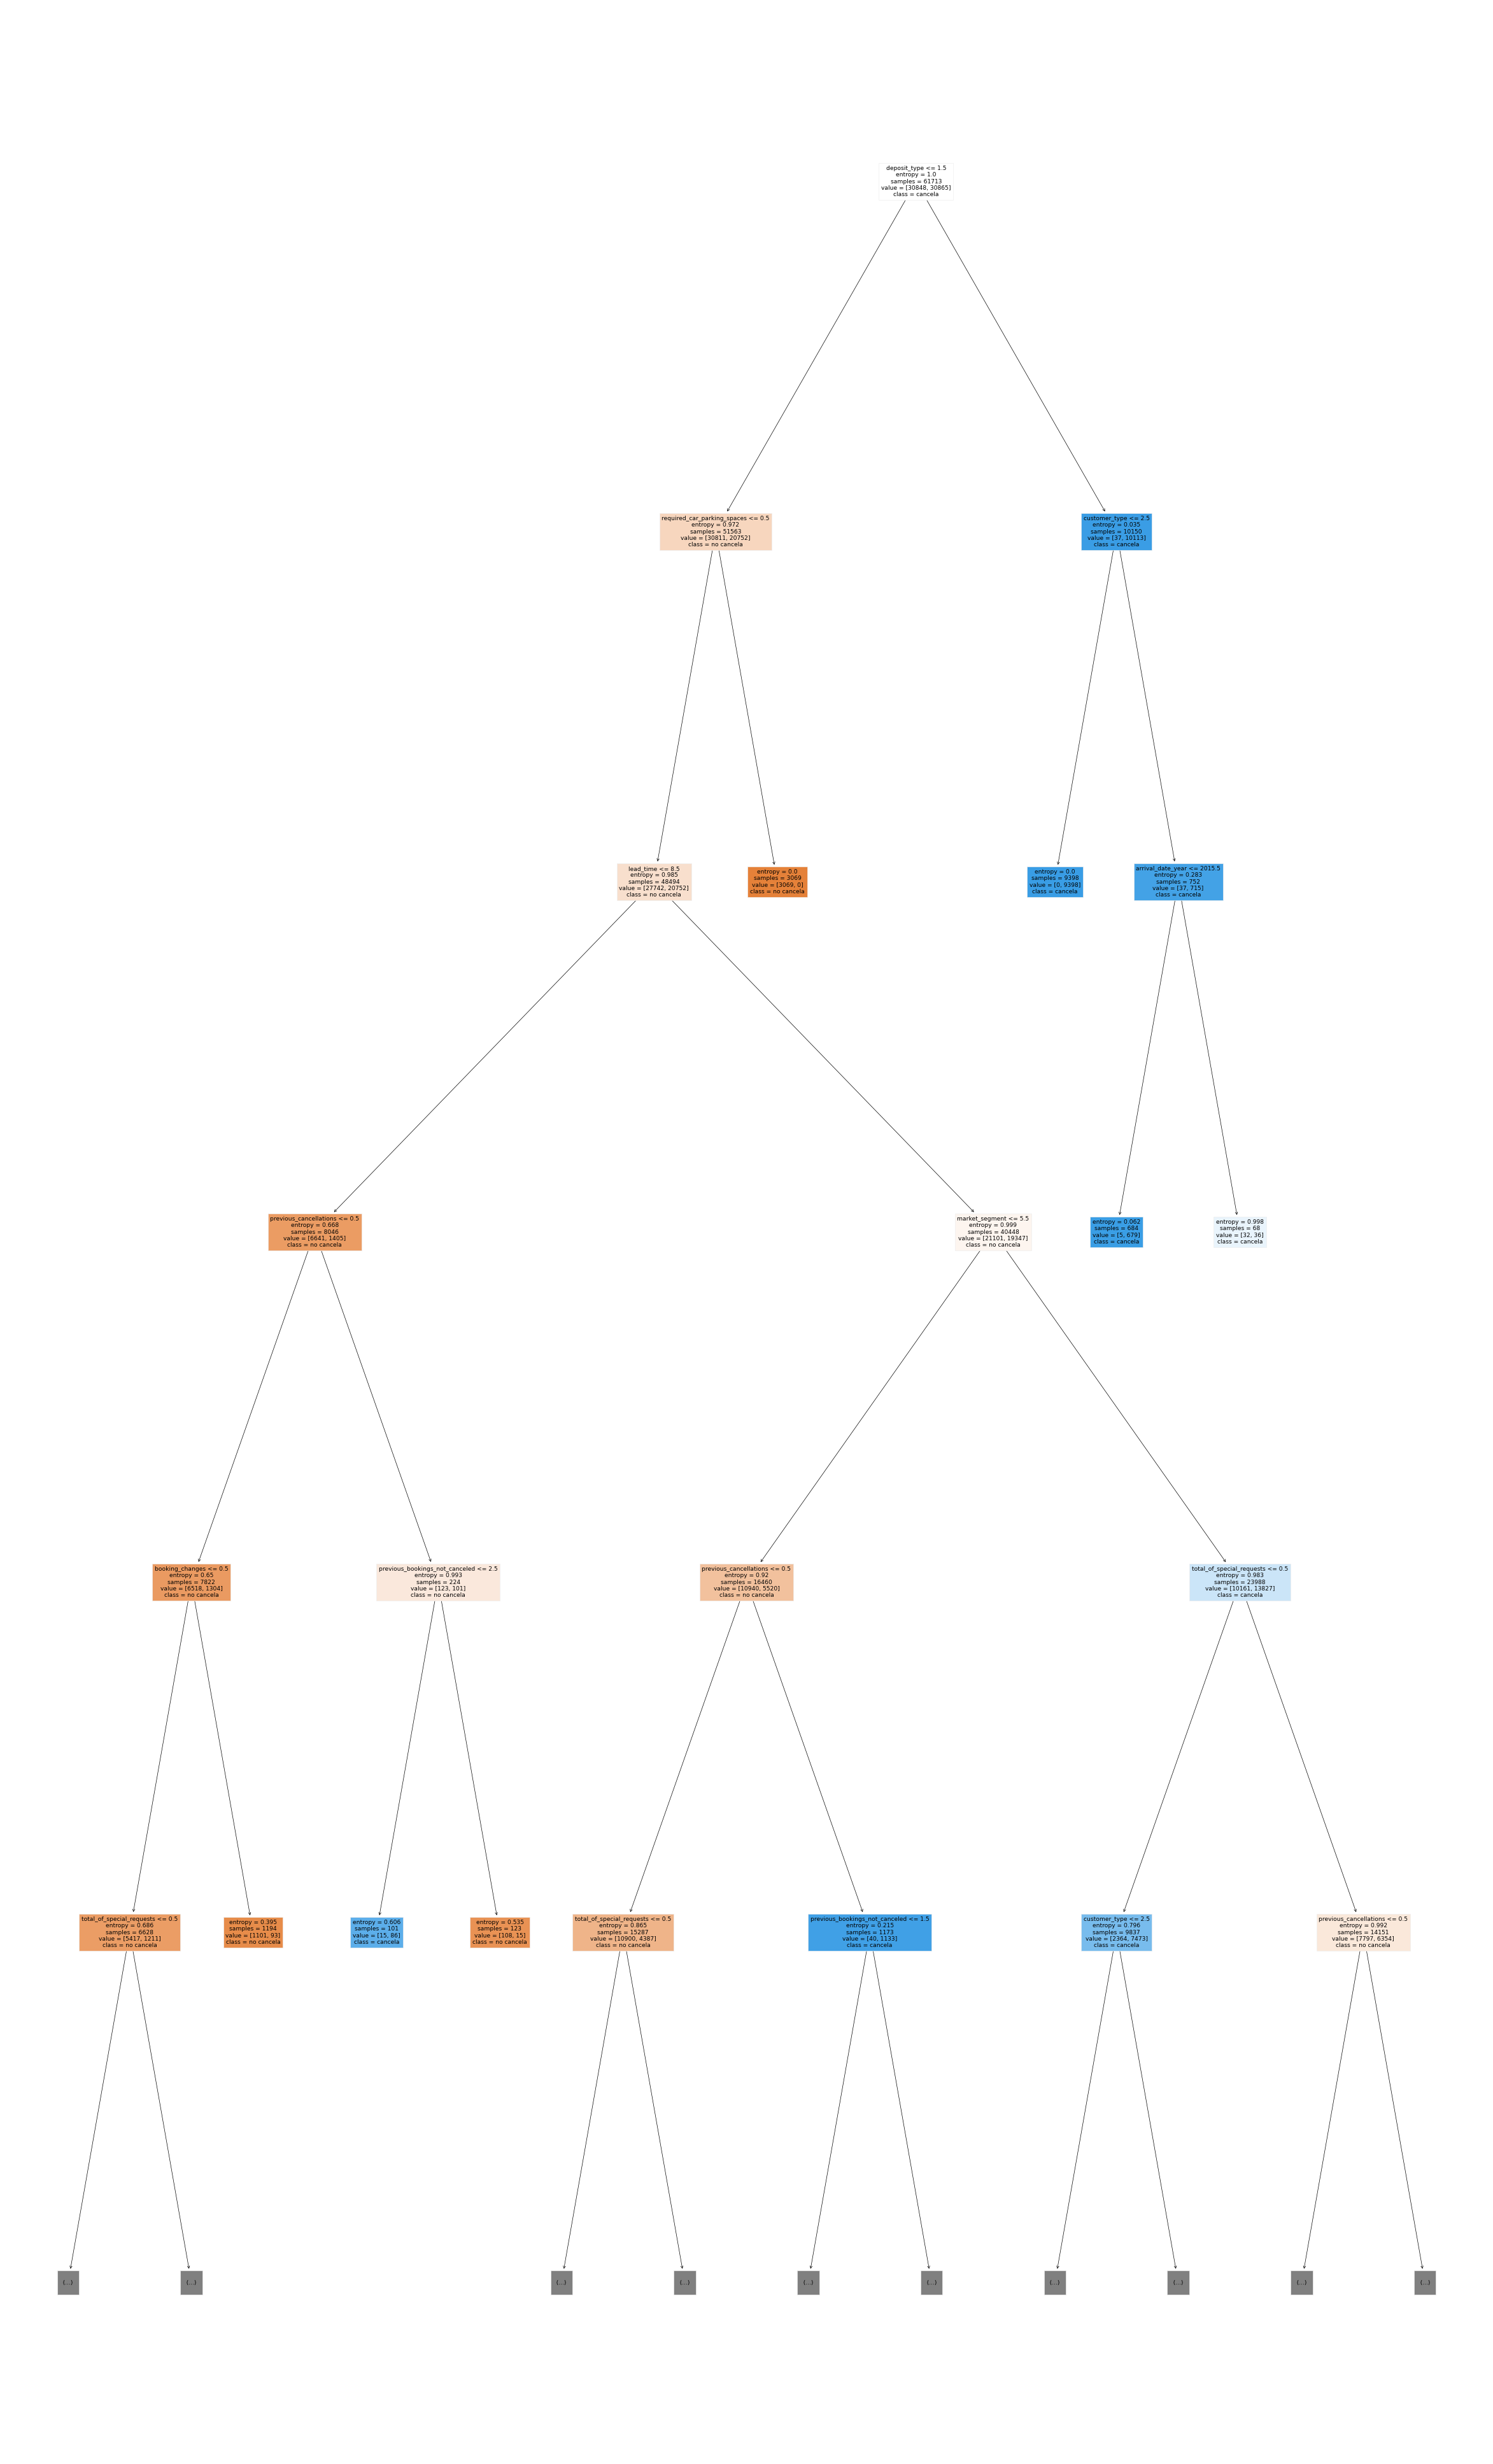

In [50]:
plt.figure(figsize=(30,50))
sk.tree.plot_tree(mejor_arbol,feature_names=features,filled=True,max_depth=5,class_names=['no cancela','cancela'])
plt.show()

Para ver una representacion significativa del arbol, cambiamos la profundidad

In [179]:
mejor_arbol = tree.DecisionTreeClassifier(
    criterion=best_params['criterion'], 
    max_depth=3, 
    min_samples_leaf=best_params['min_samples_leaf'], 
    min_samples_split=best_params['min_samples_split'], 
    ccp_alpha=best_params['ccp_alpha'])
mejor_arbol.fit(X, y)

reglas = tree.export_text(mejor_arbol, feature_names=features)
print(reglas)


|--- deposit_type <= 1.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 8.50
|   |   |   |--- class: 0
|   |   |--- lead_time >  8.50
|   |   |   |--- class: 0
|   |--- required_car_parking_spaces >  0.50
|   |   |--- class: 0
|--- deposit_type >  1.50
|   |--- customer_type <= 2.50
|   |   |--- class: 1
|   |--- customer_type >  2.50
|   |   |--- arrival_date_year <= 2015.50
|   |   |   |--- class: 1
|   |   |--- arrival_date_year >  2015.50
|   |   |   |--- class: 1



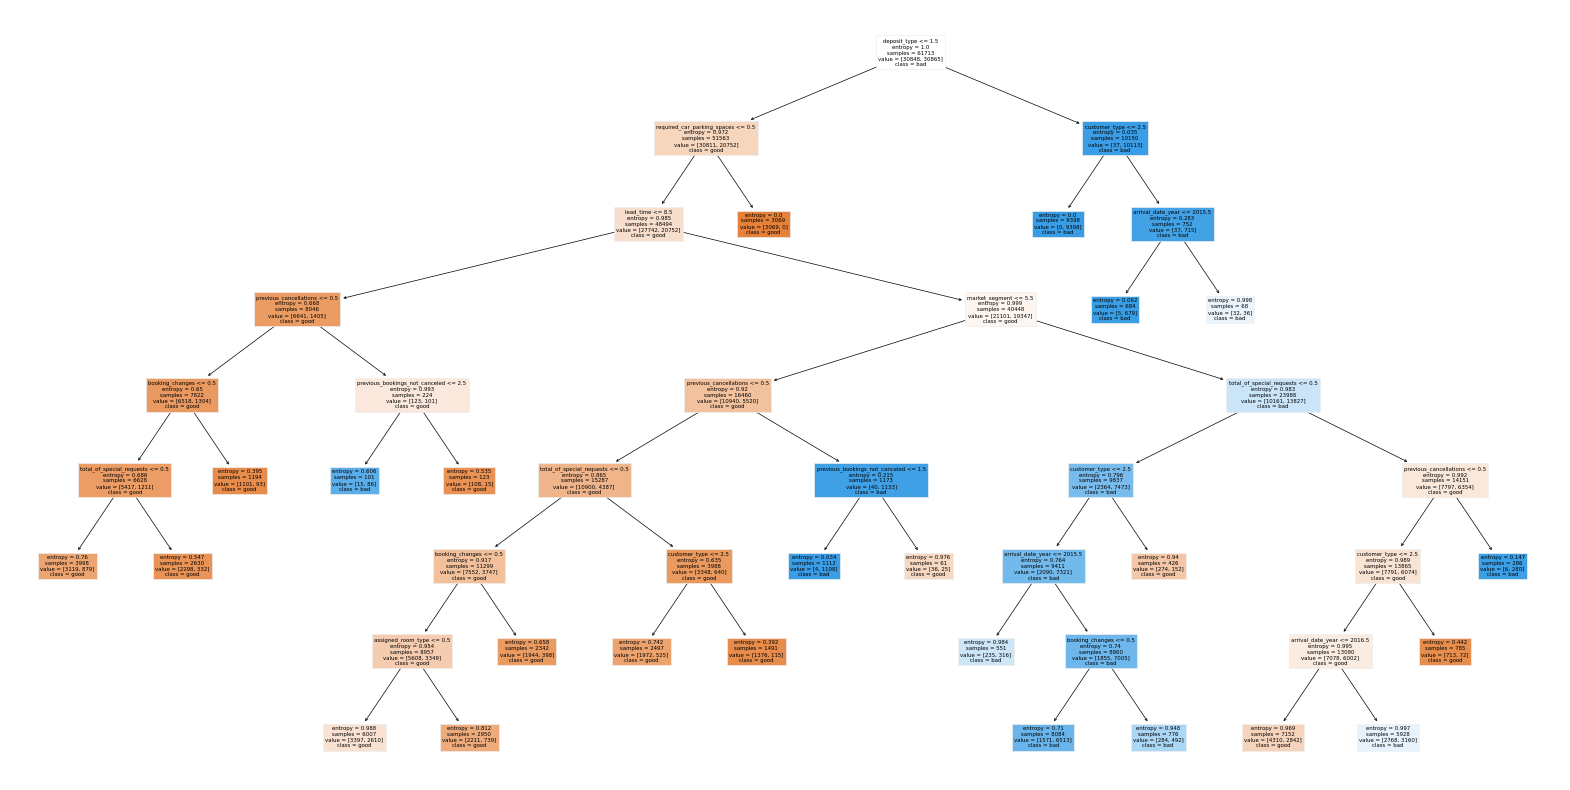

In [51]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(mejor_arbol, filled=True, feature_names=features, class_names=['good', 'bad'])
plt.show()


### Prediccion sobre el set de evaluacion y reporte

In [52]:

y_pred= mejor_arbol.predict(x_test)
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

F1-Score: 0.760950323974082


### Matriz de confusion

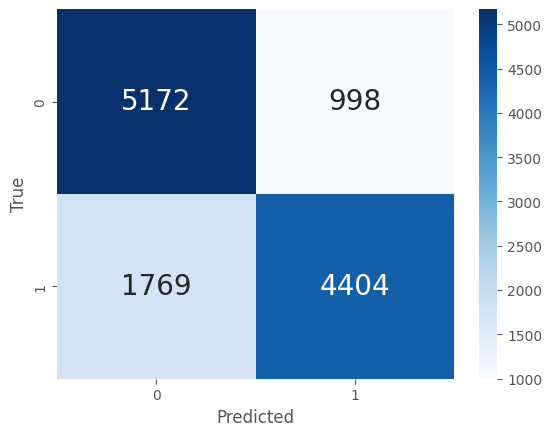

In [53]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Prediccion Kaggle

In [189]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

if 'country' in ds_test: ds_test = ds_test.drop('country', axis=1)
if 'hotel' in ds_test: ds_test = ds_test.drop('hotel', axis=1)
if 'reservation_status_date' in ds_test: ds_test = ds_test.drop('reservation_status_date', axis=1)
if 'company' in ds_test: ds_test = ds_test.drop('company', axis=1)

mejor_arbol = tree.DecisionTreeClassifier(criterion=best_params['criterion'], max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], min_samples_split=best_params['min_samples_split'], ccp_alpha=best_params['ccp_alpha'])
mejor_arbol.fit(ds[features], ds[target])

#Hago predicción sobre el set de evaluacion
y_pred = mejor_arbol.predict(ds_test[features])

# Generamos el archivo de predicciones
predicts = pd.DataFrame({'id': ds_test['id'], 'is_canceled': y_pred})
predicts.to_csv('../predicts.csv', index=False)